# Observability

Observability platforms are usually a full-fledged platform that you can connect to and transmit telemetry for real-time monitoring and future logging and reviews. We will use 2 examples of Observability platform that can be easily setup locally

## MlFlow

MlFlow is a open source platform created by Databricks as a platform for mlops. Some of the new features allow mlflow to also track prompts and LLM related observability


# MLFlow with LlamaIndex
Source: https://mlflow.org/docs/latest/llms/llama-index/index.html##enable-tracing
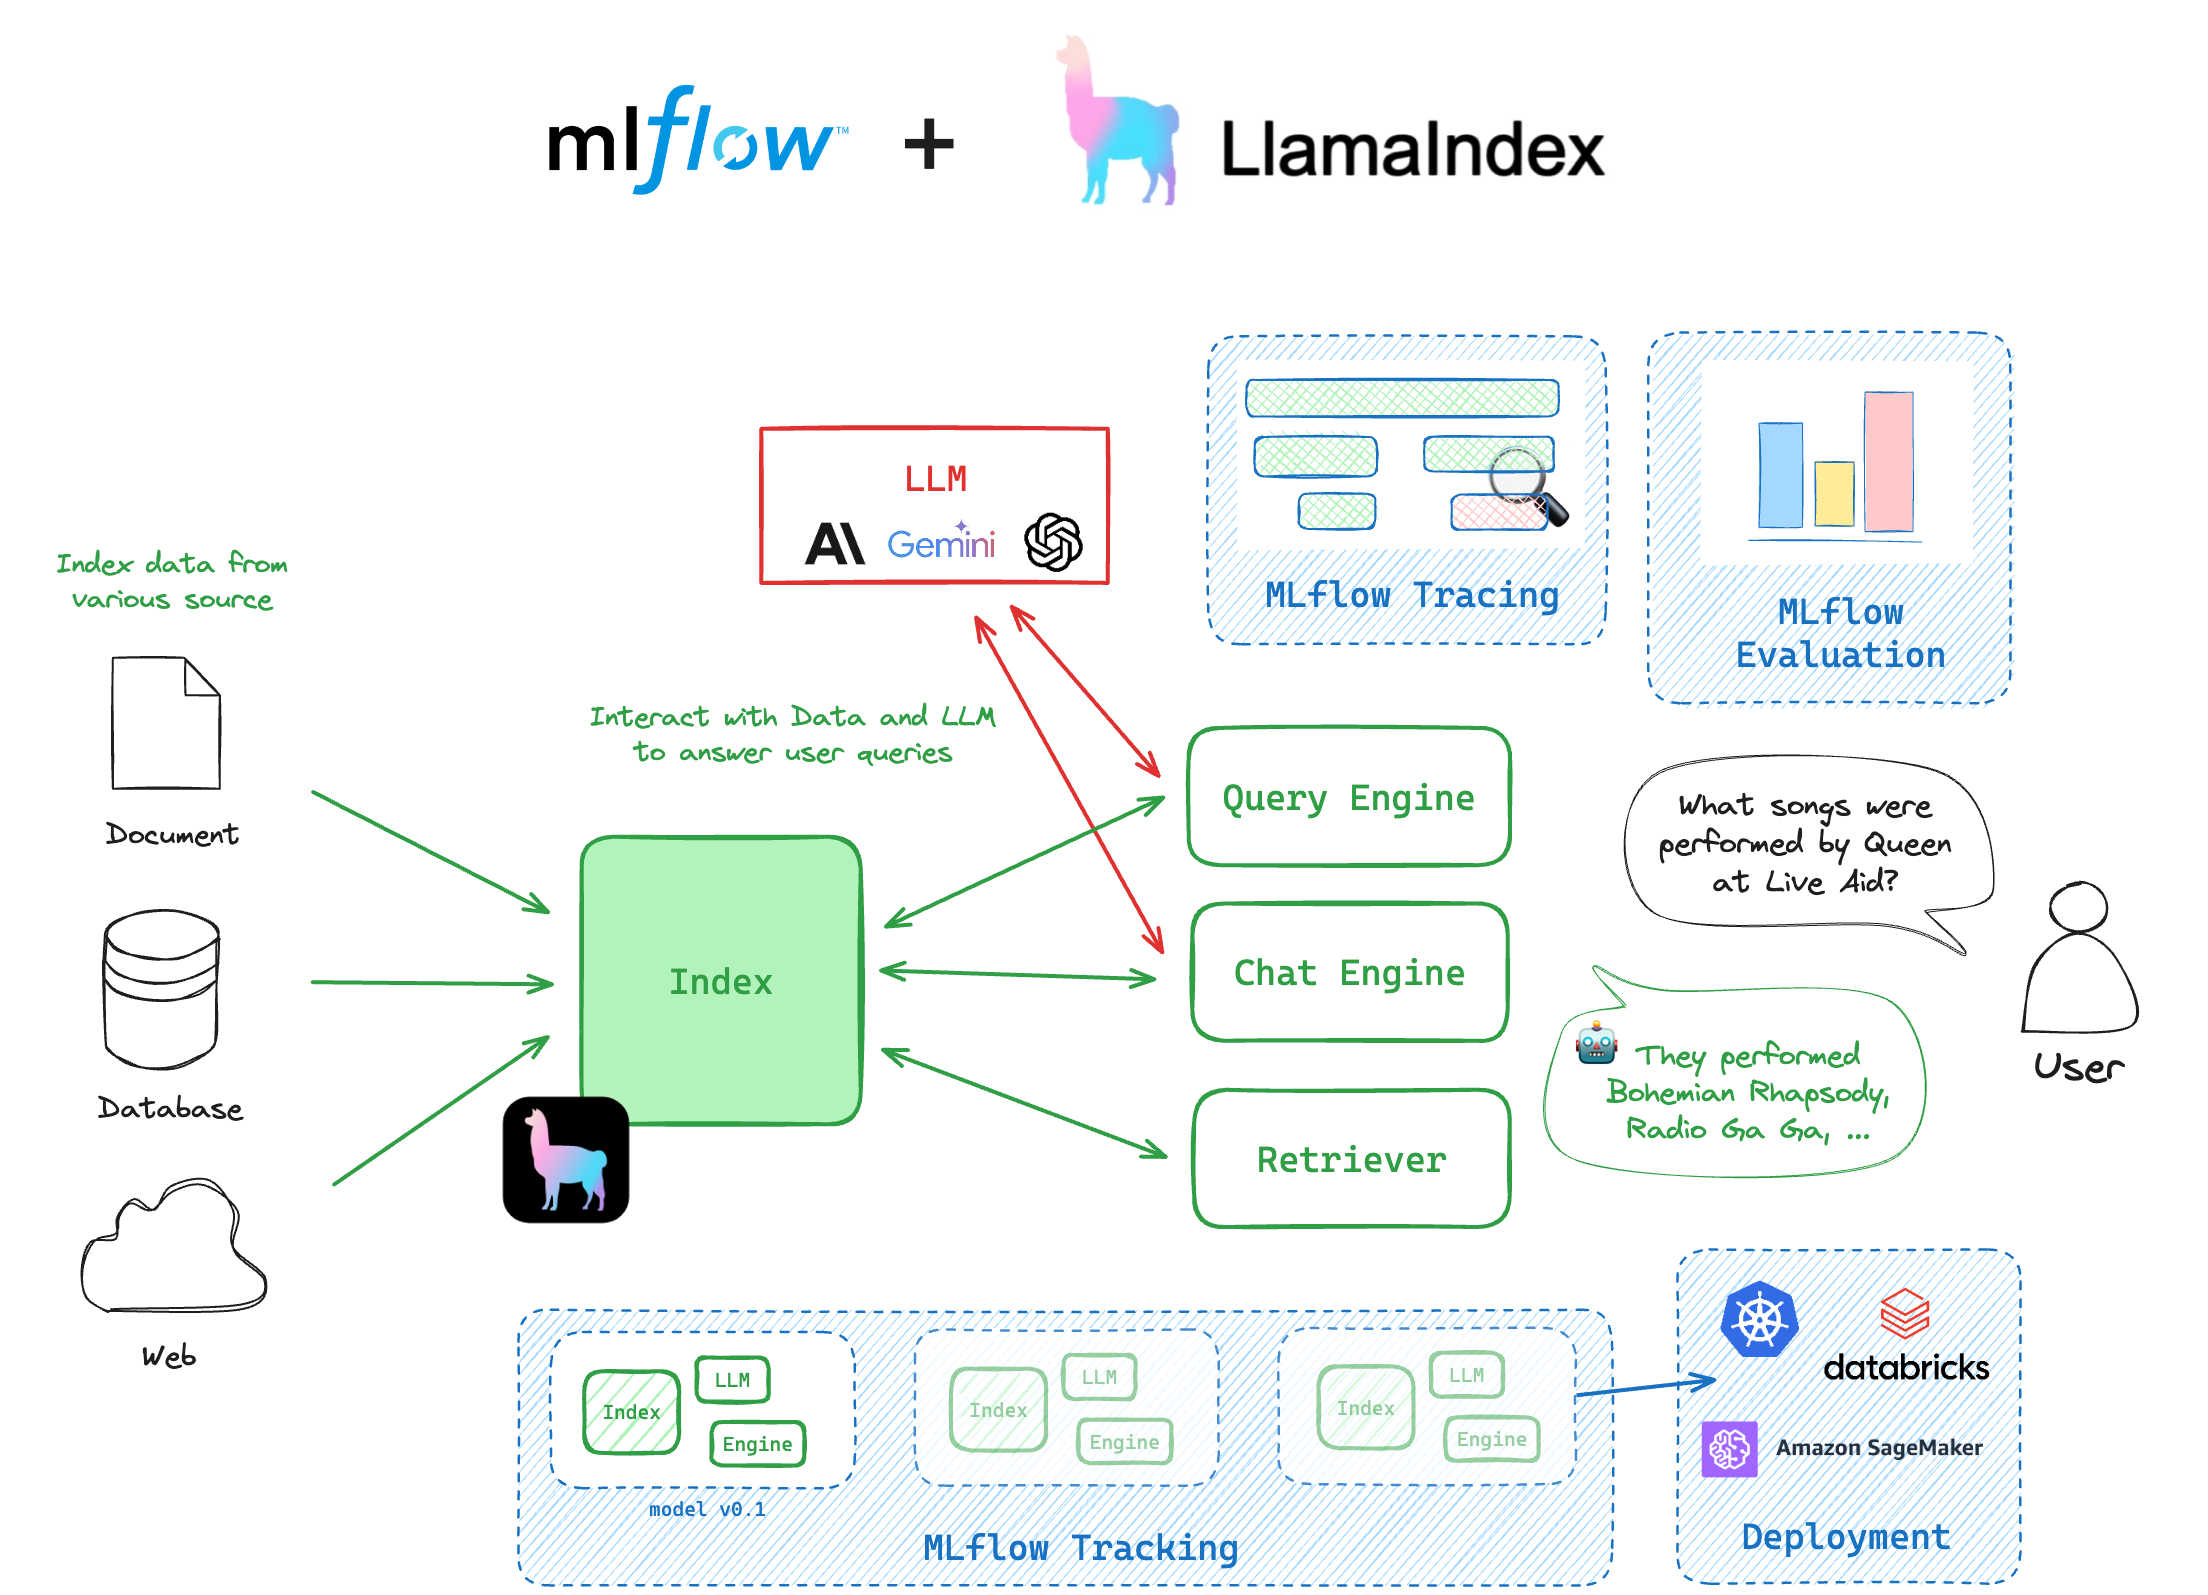

In [ ]:
import os

os.getcwd()

In [ ]:
# Initialize LlamaIndex Vector Store with OpenAI
# Do note that you have API Rate limits!!
from llama_index.core import Settings, SimpleDirectoryReader, VectorStoreIndex
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.llms.ollama import Ollama

documents = SimpleDirectoryReader("assets").load_data()

# bge-base embedding model
Settings.embed_model = HuggingFaceEmbedding(model_name="BAAI/bge-base-en-v1.5")

# ollama
Settings.llm = Ollama(model="llama3", request_timeout=360.0)

index = VectorStoreIndex.from_documents(
    documents,
)

In [ ]:
import mlflow

mlflow.set_experiment("llama-index-demo")

with mlflow.start_run():
    model_info = mlflow.llama_index.log_model(
        index,
        artifact_path="index",
        engine_type="chat",
        input_example="List Down all the tech roles that can be found in Singapore",
    )

The above code snippet passes the `index` object directly to the `log_model` function. This method only works with the default `SimpleVectorStore` vector store, which simply keeps the embedded documents in memory. If your index uses external vector stores such as `QdrantVectorStore` or `DatabricksVectorSearch`, you can use the `Model-from-Code` logging method. See the How to log an index with external vector stores for more details.

https://github.com/traceloop/openllmetry

LangFuse



RAG performance degration.. why? (link)
There are many hyper parameters that affect RAG, e.g. chunking strategy, additionally indexed metadata, etc. In general I’ve seen best results using hybrid system of RAG for fast retrieval then some sort of re-ranker, e.g. cross encoder.

https://github.com/SciPhi-AI/RAG-Performance

# Evaluations
In order to ensure that your application performs well, you need a way to judge the quality of your LLM outputs. You can do this in a variety of different ways, for example evaluating based on relevance, hallucination %, and latency.
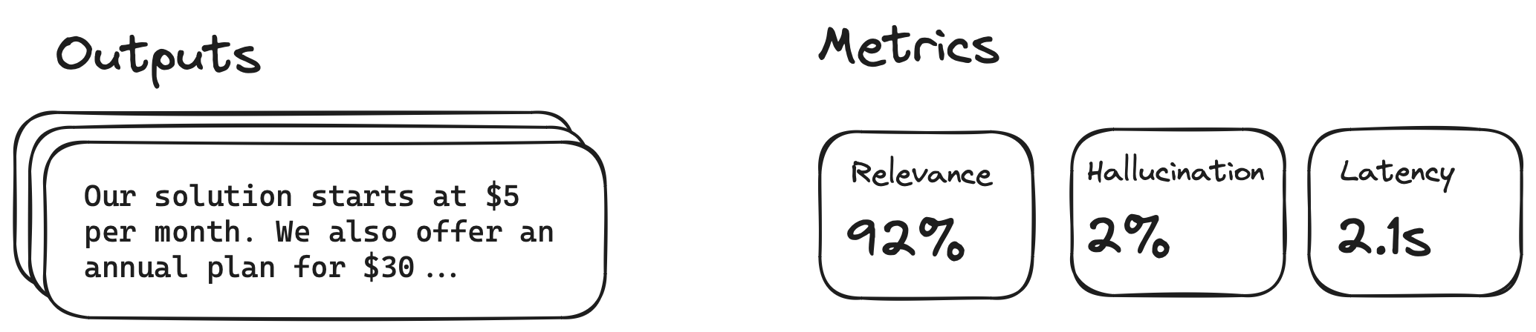

source: https://docs.arize.com/arize/llm-evaluation-and-annotations/how-does-evaluation-work

## DeepEval

- Faithfulness
- Hallucination
- Bias
- RAG



In [5]:
# To use Ollama with deepAeval, we need to configure them externally with CLI
!deepeval set-local-model --model-name="llama3" \
    --base-url="http://localhost:11434/v1/" \
    --api-key="ollama"

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


🙌 Congratulations! You're now using a local model for all evals that require an
LLM.


In [ ]:
# Faithfulness Test case
from deepeval import evaluate
from deepeval.metrics import FaithfulnessMetric
from deepeval.test_case import LLMTestCase

# Replace this with the actual output from your LLM application
actual_output = "We offer a 30-day full refund at no extra cost."

# Replace this with the actual retrieved context from your RAG pipeline
retrieval_context = ["All customers are eligible for a 30 day full refund at no extra cost."]

metric = FaithfulnessMetric(
    threshold=0.7,
    model="gpt-4",
    include_reason=True,
    async_mode=False
)
test_case = LLMTestCase(
    input="What if these shoes don't fit?",
    actual_output=actual_output,
    retrieval_context=retrieval_context

)

metric.measure(test_case)
print(metric.score)
print(metric.reason)

# or evaluate test cases in bulk
evaluate([test_case], [metric])

Output()

1.0
The score is 1.00 because there are no contradictions found between the 'actual output' and the 'retrieval context', indicating a perfect match!


✨ You're running DeepEval's latest Faithfulness Metric! (using local model, strict=False, async_mode=True)...

Event loop is already running. Applying nest_asyncio patch to allow async execution...


Evaluating 1 test case(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:14, 14.35s/test case]



Metrics Summary

  - ✅ Faithfulness (score: 1.0, threshold: 0.7, strict: False, evaluation model: local model, reason: The score is 1.00 because there are no contradictions found between the 'actual output' and the 'retrieval context', indicating a perfect match!, error: None)

For test case:

  - input: What if these shoes don't fit?
  - actual output: We offer a 30-day full refund at no extra cost.
  - expected output: None
  - context: None
  - retrieval context: ['All customers are eligible for a 30 day full refund at no extra cost.']


Overall Metric Pass Rates

Faithfulness: 100.00% pass rate




✓ Tests finished 🎉! Run 'deepeval login' to save and analyze evaluation results on Confident AI. 
‼️  Friendly reminder 😇: You can also run evaluations with ALL of deepeval's metrics directly on Confident AI 
instead.

EvaluationResult(test_results=[TestResult(success=True, metrics_data=[MetricData(name='Faithfulness', threshold=0.7, success=True, score=1.0, reason="The score is 1.00 because there are no contradictions found between the 'actual output' and the 'retrieval context', indicating a perfect match!", strict_mode=False, evaluation_model='local model', error=None, evaluation_cost=0.0, verbose_logs='Truths (limit=None):\n[\n    "All customers are eligible for a 30 day full refund.",\n    "There is no extra cost for the refund."\n] \n \nClaims:\n[\n    "We offer a 30-day full refund",\n    "At no extra cost"\n] \n \nVerdicts:\n[\n    {\n        "verdict": "yes",\n        "reason": null\n    },\n    {\n        "verdict": "yes",\n        "reason": null\n    }\n]')], conversational=False, multimodal=False, input="What if these shoes don't fit?", actual_output='We offer a 30-day full refund at no extra cost.', expected_output=None, context=None, retrieval_context=['All customers are eligible for a 

## Benchmarks
- MMLU
- HumanEval

In [ ]:
from deepeval.benchmarks import MMLU
from deepeval.metrics import AnswerRelevancyMetric

benchmark = MMLU()

## Evaluating RAG

deepeval offer 3 kinds of evaluation metrics:
- ContextualPrecisionMetric: reranker in your retriever ranks more relevant nodes in your retrieval context higher than irrelevant ones.
- ContextualRecallMetric: evaluates whether the embedding model in your retriever is able to accurately capture and retrieve relevant information based on the context of the input.
- ContextualRelevancyMetric: evaluates whether the text chunk size and top-K of your retriever is able to retrieve information without much irrelevancies.

source: https://docs.confident-ai.com/docs/guides-rag-evaluation

In [ ]:
from deepeval.metrics import (ContextualPrecisionMetric,
                              ContextualRecallMetric,
                              ContextualRelevancyMetric)
from deepeval.test_case import LLMTestCase

contextual_precision = ContextualPrecisionMetric()
contextual_recall = ContextualRecallMetric()
contextual_relevancy = ContextualRelevancyMetric()

test_case = LLMTestCase(
    input="I'm on an F-1 visa, gow long can I stay in the US after graduation?",
    actual_output="You can stay up to 30 days after completing your degree.",
    expected_output="You can stay up to 60 days after completing your degree.",
    retrieval_context=[
        """If you are in the U.S. on an F-1 visa, you are allowed to stay for 60 days after completing
        your degree, unless you have applied for and been approved to participate in OPT."""
    ]
)
contextual_precision.measure(test_case)
print("Score: ", contextual_precision.score)
print("Reason: ", contextual_precision.reason)

contextual_recall.measure(test_case)
print("Score: ", contextual_recall.score)
print("Reason: ", contextual_recall.reason)

contextual_relevancy.measure(test_case)
print("Score: ", contextual_relevancy.score)
print("Reason: ", contextual_relevancy.reason)

In [ ]:
# If you have multiple test cases and metrics, you can evaluate them in bulk as well
from deepeval import evaluate

evaluate(
    test_cases=[test_case],
    metrics=[contextual_precision, contextual_recall, contextual_relevancy]
)

# Evaluation with Arize LLM

## RAG evaluation


source: https://docs.arize.com/phoenix/retrieval/concepts-retrieval/benchmarking-retrieval-rag
source: https://colab.research.google.com/github/Arize-ai/phoenix/blob/main/tutorials/llama_index_search_and_retrieval_tutorial.ipynb#scrollTo=YEgmNVB1bAtx



In [ ]:
import os

from phoenix.evals import LiteLLMModel

os.environ["OLLAMA_API_BASE"] = "http://localhost:11434"

model = LiteLLMModel(model="ollama/llama3")